# 3. Bonus Question
K-means is an iterative algorithm, meaning that with each iteration, it refines the clusters by adjusting them based on the distance of each data point relative to the center of each cluster. This process continues until it reaches a point of convergence or hits a set limit on the number of iterations. You might want to track the progress of forming your clusters.

Select two variables* from your instances to display them on a 2D plot. Then, illustrate the progression of the clusters as they change at each iteration. We expect a plot for each iteration, displaying the instances and the clusters they belong to. Select the two features that most effectively separate visual instances belonging to different clusters. Explain the method you used to determine these features.
*Note: Depending on the variables you want to use for clustering, whether they are the original movie features or the components derived from PCA, you may select two features/components that best help to visually display the clusters.



### Movie Rating Matrix Creation 

This code processes a movie ratings dataset by first loading two CSV files containing movie and rating information. It then identifies the top 100 most reviewed movies and filters the ratings to include only those movies. Additionally, it filters the users who have given more than 144 ratings. Finally, it creates a pivot table, where the rows represent active users, the columns represent movie titles, and the values are the corresponding ratings. 
Where a user has not rated a movie, the missing rating is filled with the average rating of that movie. 

In [12]:
import pandas as pd

movies = pd.read_csv('/kaggle/input/movielens-20m-dataset/movie.csv')  # movieId, title, genres
ratings = pd.read_csv('/kaggle/input/movielens-20m-dataset/rating.csv')  # userId, movieId, rating, timestamp

# 2. Count the reviews for each movie
top_movies = (ratings['movieId']
              .value_counts()
              .head(100)
              .index)  # Get the IDs of the 100 most reviewed movies

# Filter the movies dataset to get the movie titles
top_movies_df = movies[movies['movieId'].isin(top_movies)]

# 3. Filter users with more than 144 reviews
active_users = (ratings['userId']
                .value_counts()
                .loc[lambda x: x > 144]
                .index)  # Get the IDs of the active users

# Filter the ratings dataset to include only the selected movies and users
filtered_ratings = ratings[(ratings['movieId'].isin(top_movies)) & (ratings['userId'].isin(active_users))]


# Merge with the movies dataset to include the titles
filtered_ratings = filtered_ratings.merge(movies[['movieId', 'title']], on='movieId')

# Create a pivot table with users as rows and movie titles as columns
rating_matrix = filtered_ratings.pivot_table(index='userId',
                                             columns='title',
                                             values='rating')


rating_matrix_filled = rating_matrix.apply(lambda col: col.fillna(col.mean()), axis=0)
rating_matrix_filled.head()



title,2001: A Space Odyssey (1968),Ace Ventura: Pet Detective (1994),Aladdin (1992),Alien (1979),Aliens (1986),American Beauty (1999),Apollo 13 (1995),Austin Powers: The Spy Who Shagged Me (1999),Babe (1995),Back to the Future (1985),...,There's Something About Mary (1998),Titanic (1997),Toy Story (1995),True Lies (1994),Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Twister (1996),"Usual Suspects, The (1995)",Waterworld (1995),Willy Wonka & the Chocolate Factory (1971),X-Men (2000)
userId,,,,,,,,,,,,,,,,,,,,,
1,3.500000,2.961599,3.646345,4.000000,4.000000,4.131091,3.75601,3.500000,3.503323,3.912919,...,3.521537,3.269954,3.874549,3.411887,3.500000,3.001004,3.500000,2.685461,3.726631,3.585166
3,5.000000,2.961599,3.646345,5.000000,4.000000,4.131091,3.75601,3.165235,3.503323,5.000000,...,3.521537,4.000000,4.000000,3.411887,4.000000,3.001004,5.000000,2.685461,5.000000,3.585166
7,3.000000,2.961599,3.646345,4.030478,3.989787,3.000000,3.75601,3.000000,3.503323,4.000000,...,3.521537,5.000000,3.874549,3.411887,3.939647,3.000000,4.322263,2.685461,3.726631,4.000000
11,3.933011,3.500000,5.000000,5.000000,5.000000,5.000000,5.00000,0.500000,3.503323,5.000000,...,3.521537,4.000000,4.500000,5.000000,5.000000,5.000000,4.322263,4.500000,5.000000,5.000000
14,3.500000,2.000000,4.000000,4.030478,3.989787,4.131091,5.00000,3.165235,3.000000,4.000000,...,3.521537,2.000000,4.500000,3.411887,3.939647,3.001004,4.322263,2.685461,3.000000,3.585166


### Applying Singular Value Decomposition (SVD)

In this section, Singular Value Decomposition (SVD) is applied to the user-item rating matrix to reduce its dimensionality. The SVD decomposition produces three matrices: **U** (user features), **S** (singular values), and **Vt** (movie features). The matrix **Vt** is transposed and then transformed into a DataFrame with movie titles as the index and latent dimensions as columns. This reduced representation helps in understanding the hidden relationships between users and movies for recommendation tasks.


In [13]:
from sklearn.decomposition import TruncatedSVD

# Apply SVD (Singular Value Decomposition)
svd = TruncatedSVD(n_components=50, random_state=42)  # Set the number of latent components to 50
U = svd.fit_transform(rating_matrix_filled)  # Perform the SVD and get the U matrix (user features)
S = svd.singular_values_  # Get the singular values
Vt = svd.components_  # Vt is the transpose of the V matrix (movie features)

print("Shape of Vt:", Vt.shape)

# Retrieve the movie titles from the original matrix columns
film_titles = rating_matrix_filled.columns

# Create a DataFrame for V^T with movie titles as the index
Vt_df = pd.DataFrame(Vt.T, index=film_titles, columns=[f'Latent_Dim_{i+1}' for i in range(Vt.shape[0])])


Vt_df.head()


Shape of Vt: (50, 100)


,Latent_Dim_1,Latent_Dim_2,Latent_Dim_3,Latent_Dim_4,Latent_Dim_5,Latent_Dim_6,Latent_Dim_7,Latent_Dim_8,Latent_Dim_9,Latent_Dim_10,...,Latent_Dim_41,Latent_Dim_42,Latent_Dim_43,Latent_Dim_44,Latent_Dim_45,Latent_Dim_46,Latent_Dim_47,Latent_Dim_48,Latent_Dim_49,Latent_Dim_50
title,,,,,,,,,,,,,,,,,,,,,
2001: A Space Odyssey (1968),0.104612,0.175997,0.052497,0.007140,0.091154,0.045626,0.051316,0.073114,-0.321496,-0.045412,...,0.108641,-0.102289,0.164814,0.067368,-0.203503,-0.010921,0.104177,-0.113740,0.033910,0.069795
Ace Ventura: Pet Detective (1994),0.079051,-0.090426,0.016270,0.246669,-0.034212,0.043906,-0.420543,0.074675,-0.097533,0.088544,...,0.053364,-0.047652,0.013980,0.021279,0.015012,-0.019633,0.377361,-0.169218,-0.014229,-0.072191
Aladdin (1992),0.097218,-0.078187,0.065363,-0.132274,0.124141,0.084473,-0.091427,0.012941,0.132425,0.123774,...,-0.015386,0.026748,-0.029549,-0.067090,-0.032057,-0.056689,-0.020101,-0.001912,-0.074816,-0.056420
Alien (1979),0.107355,0.105329,-0.071648,0.072327,0.148029,0.003840,0.071789,-0.202584,-0.160747,-0.036415,...,0.025213,0.028012,0.045221,-0.007477,-0.005220,-0.002867,0.007186,0.001325,0.033350,0.124298
Aliens (1986),0.106284,0.059655,-0.092267,0.084941,0.123193,-0.012488,0.074526,-0.200664,-0.105956,0.001779,...,0.051393,0.012208,0.094383,-0.012413,-0.033278,0.013067,0.067711,0.019036,0.109571,0.116694


### Standardizing the Latent Features

In this section, the latent features (from the matrix **Vt**) are standardized using **StandardScaler**. Standardization transforms the data such that each feature (latent dimension) has a mean of 0 and a standard deviation of 1. This step ensures that all features are on the same scale, making it easier to compare them or use them in further analysis, such as clustering or classification tasks.


In [14]:
from sklearn.preprocessing import StandardScaler

# Create a scaler for standardization
scaler = StandardScaler()

# Apply standardization to each column (latent dimension)
Vt_standardized = scaler.fit_transform(Vt_df)  

# Create a new DataFrame with the standardized data
Vt_standardized_df = pd.DataFrame(Vt_standardized, index=Vt_df.index, columns=Vt_df.columns)

# Print a preview of the standardized DataFrame
Vt_standardized_df.head()



,Latent_Dim_1,Latent_Dim_2,Latent_Dim_3,Latent_Dim_4,Latent_Dim_5,Latent_Dim_6,Latent_Dim_7,Latent_Dim_8,Latent_Dim_9,Latent_Dim_10,...,Latent_Dim_41,Latent_Dim_42,Latent_Dim_43,Latent_Dim_44,Latent_Dim_45,Latent_Dim_46,Latent_Dim_47,Latent_Dim_48,Latent_Dim_49,Latent_Dim_50
title,,,,,,,,,,,,,,,,,,,,,
2001: A Space Odyssey (1968),0.474022,1.841649,0.492221,0.040609,0.912072,0.419969,0.522391,0.707435,-3.189260,-0.446334,...,1.086947,-1.017964,1.648659,0.672622,-2.031769,-0.111357,1.045895,-1.141590,0.337449,0.702623
Ace Ventura: Pet Detective (1994),-1.847193,-0.830373,0.129751,2.437044,-0.341594,0.402754,-4.196407,0.723058,-0.948819,0.893265,...,0.534179,-0.471593,0.140327,0.211732,0.153392,-0.198469,3.777754,-1.696370,-0.143939,-0.717256
Aladdin (1992),-0.197449,-0.707626,0.620948,-1.354191,1.241941,0.808694,-0.905098,0.105533,1.351585,1.245578,...,-0.153325,0.272422,-0.294967,-0.671955,-0.317307,-0.569039,-0.196902,-0.023293,-0.749815,-0.559537
Alien (1979),0.723129,1.132896,-0.749911,0.692791,1.480825,0.001822,0.727124,-2.050330,-1.581192,-0.356361,...,0.252669,0.285060,0.452736,-0.075825,-0.048926,-0.030809,0.075971,0.009069,0.331853,1.247655
Aliens (1986),0.625896,0.674828,-0.956214,0.818989,1.232466,-0.161562,0.754494,-2.031124,-1.033086,0.025588,...,0.514470,0.127017,0.944358,-0.125182,-0.329510,0.128524,0.681228,0.186187,1.094060,1.171617


### K-Means Clustering: Elbow and Silhouette Methods

In this section, two methods are applied to determine the optimal number of clusters for K-Means clustering:

1. **Elbow Method**: This method calculates the inertia (sum of squared distances of samples to their closest cluster center) for different numbers of clusters. By plotting the inertia, the "elbow" point can be identified, which suggests the optimal number of clusters.
   
2. **Silhouette Method**: This method calculates the silhouette score for each cluster configuration. The silhouette score measures how similar each point is to its own cluster compared to other clusters. A higher silhouette score indicates better-defined clusters. Both methods help in selecting the best number of clusters for the given data.


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

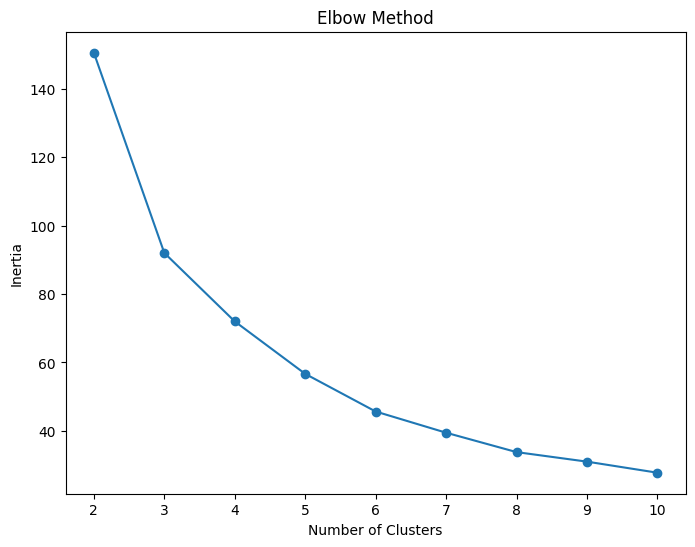

Number of clusters: 2, Silhouette Score: 0.4377
Number of clusters: 3, Silhouette Score: 0.4495
Number of clusters: 4, Silhouette Score: 0.4094
Number of clusters: 5, Silhouette Score: 0.4101
Number of clusters: 6, Silhouette Score: 0.4057
Number of clusters: 7, Silhouette Score: 0.4175
Number of clusters: 8, Silhouette Score: 0.4070
Number of clusters: 9, Silhouette Score: 0.3821
Number of clusters: 10, Silhouette Score: 0.3559


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

In [19]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Elbow Method
inertia = []  # List to store the inertia for each number of clusters
range_n_clusters = range(2, 11)  # Try cluster numbers from 2 to 10

# Calculate inertia for each number of clusters
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method result
plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Silhouette Method for cluster numbers from 2 to 10
silhouette_scores = []  # List to store silhouette scores
range_n_clusters = range(2, 11)

# Calculate silhouette score for each number of clusters
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)
    print(f"Number of clusters: {n_clusters}, Silhouette Score: {silhouette_avg:.4f}")


### K-Means Clustering Animation with PCA and Movie Titles

In this section, we apply K-Means clustering to a dataset that has been reduced to 2D using **Principal Component Analysis (PCA)** for visualization. The animation shows how the K-Means clustering algorithm iterates through its steps, updating the cluster assignments and centroid positions over time.

The **scatter plot** displays the movie data points in the 2D PCA space, colored according to their cluster assignment. **Centroids** (red 'X' markers) are shown as the cluster centers, and **annotations** show the movie titles at each point. The animation saves as a GIF to visually explore the clustering process over 10 iterations.

This approach allows for better understanding of how K-Means works, particularly when visualizing the changes in cluster formation over time.


/tmp/ipykernel_30/2279236943.py:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c='gray', cmap="viridis", s=50)


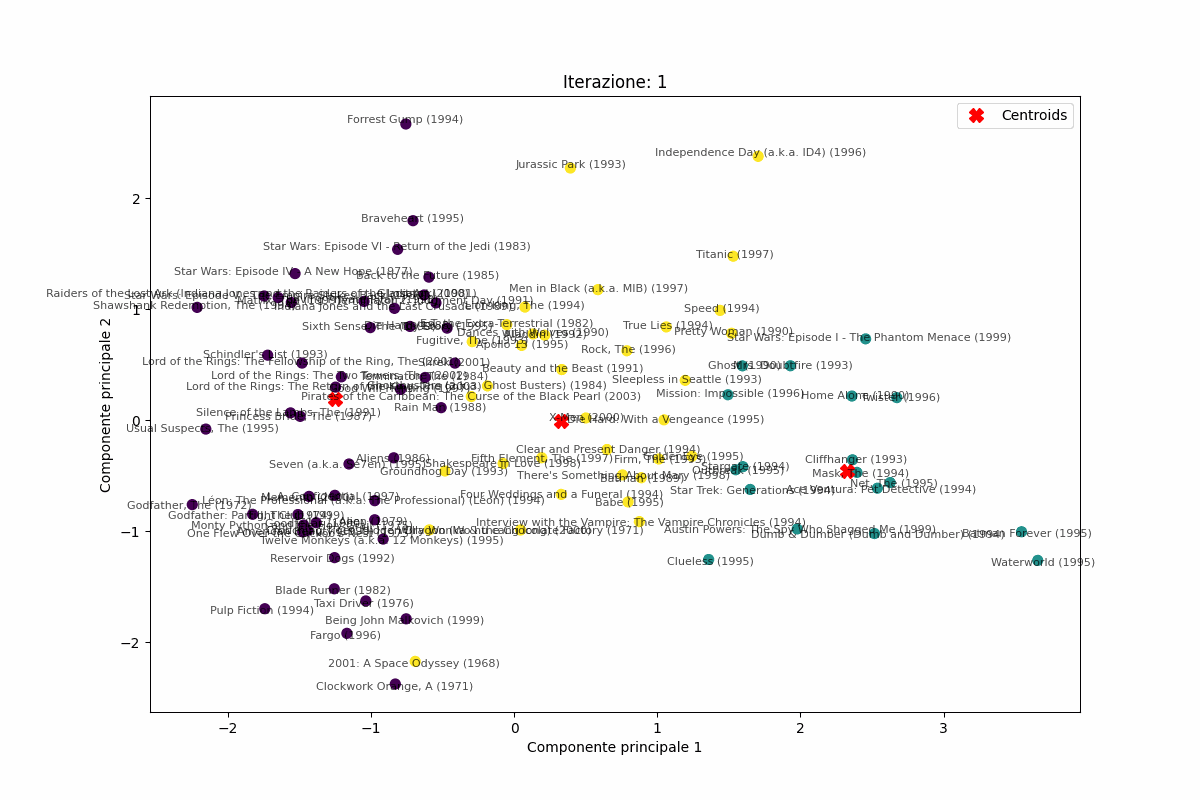

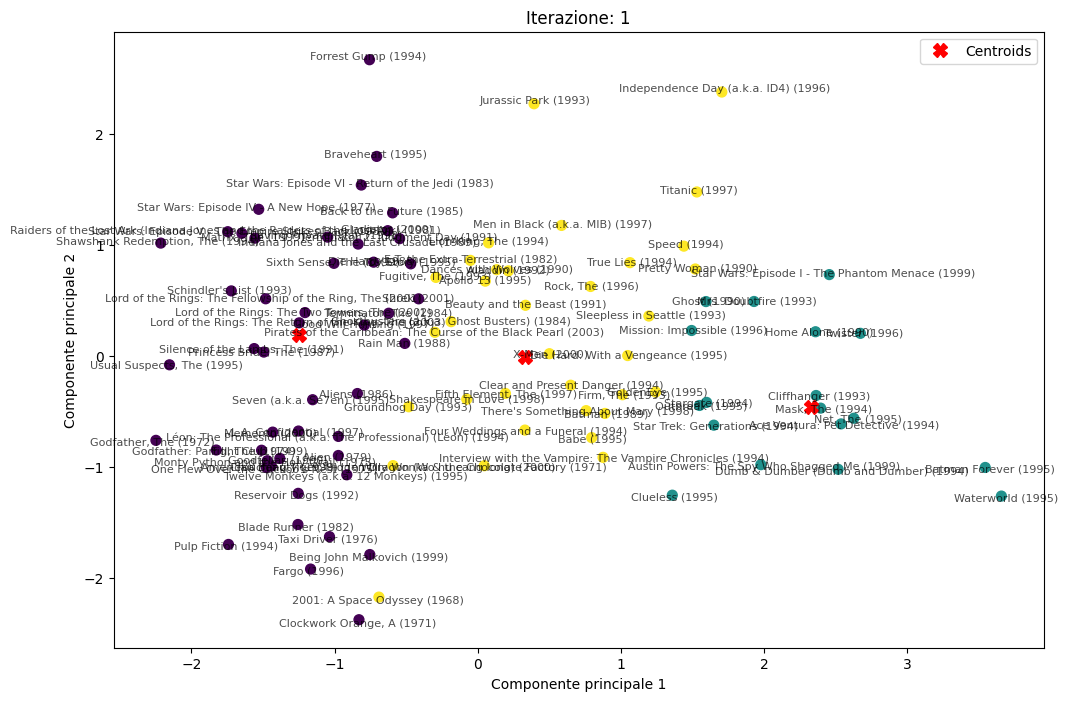

In [11]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

# Assume that Vt_standardized_df is a Pandas DataFrame with movies as rows
# The movie titles are in the index of the rows

# Reduce dimensionality to 2 with PCA (for 2D visualization)
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(Vt_standardized_df)

# Reduced data for animation
X_scaled = reduced_data  # PCA-reduced data for animation

# Number of clusters
num_clusters = 3

# Create figure for the animation
fig, ax = plt.subplots(figsize=(12, 8))

# Initial scatter plot
scatter = ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c='gray', cmap="viridis", s=50)

# Initial centroids (will be updated during the animation)
centroids_plot, = ax.plot([], [], 'rX', markersize=10, label='Centroids')

# Add annotations for movie titles
annotations = [ax.annotate(txt, (X_scaled[i, 0], X_scaled[i, 1]), fontsize=8, alpha=0.7, 
                           xytext=(5, 5), textcoords='offset points', ha='center', va='center')
               for i, txt in enumerate(Vt_standardized_df.index)]

ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_title("K-Means Clustering Animation")
ax.legend()

# Update function for the animation
def update(frame):
    # Initialize K-means and apply iterations up to the frame number
    kmeans = KMeans(n_clusters=num_clusters, init="random", max_iter=frame+1, n_init=1, random_state=42)
    kmeans.fit(X_scaled)
    labels = kmeans.predict(X_scaled)
    centroids = kmeans.cluster_centers_  # Reduced centroids

    # Update point colors based on clusters
    scatter.set_offsets(X_scaled)  # Update scatter data
    scatter.set_array(labels)  # Update point colors

    # Update centroid positions
    centroids_plot.set_data(centroids[:, 0], centroids[:, 1])  # Centroids in 2D space

    # Update movie title annotations
    for i, txt in enumerate(Vt_standardized_df.index):
        annotations[i].set_position((X_scaled[i, 0], X_scaled[i, 1]))  # Update title position

    ax.set_title(f"Iteration: {frame + 1}")
    return scatter, centroids_plot, *annotations

# Create the animation
anim = FuncAnimation(fig, update, frames=10, interval=500, blit=False)

# Save the animation as a GIF
gif_path = "kmeans_animation_2d.gif"
anim.save(gif_path, writer=PillowWriter(fps=2))

# Display the GIF animation (optional, only in Jupyter environments)
from IPython.display import Image
display(Image(filename=gif_path))


In [29]:
# Perform K-means to obtain clusters
kmeans = KMeans(n_clusters=num_clusters, init="random", max_iter=10, n_init=1, random_state=42)
kmeans.fit(X_scaled)

# Cluster labels for each movie
labels = kmeans.labels_

# Print movie titles for each cluster
for cluster_num in range(num_clusters):
    print(f"\nMovies in cluster {cluster_num + 1}:")
    cluster_movies = Vt_standardized_df.index[labels == cluster_num]  # Filter movies by cluster
    for movie in cluster_movies:
        print(movie)



Film nel cluster 1:
2001: A Space Odyssey (1968)
Alien (1979)
Aliens (1986)
American Beauty (1999)
Being John Malkovich (1999)
Blade Runner (1982)
Clockwork Orange, A (1971)
Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000)
Fargo (1996)
Fight Club (1999)
Godfather, The (1972)
Godfather: Part II, The (1974)
Goodfellas (1990)
Groundhog Day (1993)
L.A. Confidential (1997)
Lord of the Rings: The Return of the King, The (2003)
Léon: The Professional (a.k.a. The Professional) (Léon) (1994)
Memento (2000)
Monty Python and the Holy Grail (1975)
One Flew Over the Cuckoo's Nest (1975)
Princess Bride, The (1987)
Pulp Fiction (1994)
Reservoir Dogs (1992)
Schindler's List (1993)
Seven (a.k.a. Se7en) (1995)
Shakespeare in Love (1998)
Silence of the Lambs, The (1991)
Taxi Driver (1976)
Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
Usual Suspects, The (1995)
Willy Wonka & the Chocolate Factory (1971)

Film nel cluster 2:
Ace Ventura: Pet Detective (1994)
Austin Powers: The Spy Who Shagged Me (1999)

# Analyzing Patterns in Movie Clusters

The provided film clusters exhibit distinct patterns, reflecting specific themes, genres, or audience preferences. Below is a breakdown of the characteristics and commonalities within each cluster:


## **Cluster 1: Critically Acclaimed and Thought-Provoking Masterpieces**

### **Characteristics**
- **Genre:** This cluster is dominated by dramas, thrillers, and thought-provoking films, often with a dark or cerebral tone.
- **Themes:** Exploration of morality, identity, societal issues, and human behavior is central. Many films delve into psychological depth or philosophical questions.
- **Style:** High artistic value with innovative cinematography, storytelling techniques, and complex narratives.
- **Awards and Recognition:** Many of these films are Oscar winners or nominees, reflecting their critical acclaim.

### **Examples**
- *2001: A Space Odyssey* and *Blade Runner* showcase groundbreaking science fiction with philosophical undertones.
- *Pulp Fiction* and *Reservoir Dogs* highlight Tarantino's iconic nonlinear storytelling and stylized violence.
- *Schindler's List* and *The Godfather* emphasize powerful drama rooted in historical or familial contexts.
- *Fight Club* and *Memento* explore psychological themes and unconventional narrative structures.

### **Audience**
This cluster appeals to cinephiles and viewers seeking depth, intellectual engagement, and artistic excellence.


## **Cluster 2: Popular Entertainment and Mainstream Appeal**

### **Characteristics**
- **Genre:** A mix of action, comedy, romance, and light drama, designed for broad, mainstream appeal.
- **Themes:** Focus on humor, romance, and fast-paced storytelling, often with lighter, feel-good, or action-packed tones.
- **Style:** Straightforward plots, high-energy sequences, and relatable characters make these films easily digestible.
- **Box Office Success:** These films often prioritize commercial appeal, with many being blockbusters or franchise entries.

### **Examples**
- Comedies like *Ace Ventura: Pet Detective* and *Dumb & Dumber* lean on slapstick humor and eccentric characters.
- Romantic films like *Pretty Woman* and *Sleepless in Seattle* focus on charming narratives and emotional resonance.
- Action-packed films such as *Die Hard: With a Vengeance* and *True Lies* feature thrilling sequences and charismatic leads.
- Franchises like *Mission: Impossible* and *Star Wars: Episode I - The Phantom Menace* cater to established fanbases.

### **Audience**
This cluster targets casual moviegoers seeking entertainment, humor, and escapism.


## **Cluster 3: Iconic Blockbusters and Family Favorites**

### **Characteristics**
- **Genre:** A blend of action-adventure, science fiction, fantasy, and family-friendly films with universal themes.
- **Themes:** Heroic journeys, larger-than-life adventures, and inspirational storytelling dominate this cluster.
- **Style:** High production value, iconic soundtracks, and memorable characters make these films culturally significant.
- **Legacy:** Many of these films are enduring classics, spawning sequels, franchises, or becoming cultural phenomena.

### **Examples**
- *Star Wars: Episode IV - A New Hope* and *The Matrix* redefined science fiction and action genres.
- Family-friendly classics like *The Lion King* and *Toy Story* combine emotional depth with broad appeal.
- Adventure films such as *Indiana Jones and the Last Crusade* and *Jurassic Park* offer thrilling escapades.
- Blockbusters like *Saving Private Ryan* and *The Shawshank Redemption* balance emotional weight with mass appeal.

### **Audience**
This cluster appeals to a wide range of viewers, from families to fans of epic storytelling and action-packed adventures.


